# 

In [1]:
%pip install skyfield
%pip install tzwhere
%pip install geopy
%pip install pytz

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
%pip install matplotlib
%pip install pandas

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
#install the required libraries for the first time 
#!pip install skyfield
#!pip install tzwhere
#!pip install geopy

from datetime import datetime
from geopy import Nominatim
from tzwhere import tzwhere
from pytz import timezone, utc

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle

from skyfield.api import Star, load, wgs84
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.projections import build_stereographic_projection
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN

In [4]:
def load_data():
    # de421 shows position of earth and sun in space
    eph = load('de421.bsp')

    # hipparcos dataset
    with load.open(hipparcos.URL) as f:
        stars = hipparcos.load_dataframe(f)

    # constellation dataset
    url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
           '/skycultures/modern_st/constellationship.fab')

    with load.open(url) as f:
        constellations = stellarium.parse_constellations(f)
        
    return eph, stars, constellations
        
# load celestial data
eph, stars, constellations = load_data()

In [39]:
%pip install timezonefinder
import timezonefinder, pytz


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


                                              0.0/46.9 MB ? eta -:--:--
                                              0.3/46.9 MB 8.6 MB/s eta 0:00:06
                                              1.0/46.9 MB 12.3 MB/s eta 0:00:04
     -                                        1.9/46.9 MB 15.5 MB/s eta 0:00:03
     --                                       2.8/46.9 MB 16.4 MB/s eta 0:00:03
     ---                                      3.8/46.9 MB 17.3 MB/s eta 0:00:03
     ---                                      4.5/46.9 MB 17.1 MB/s eta 0:00:03
     ----                                     5.3/46.9 MB 17.0 MB/s eta 0:00:03
     -----                                    6.0/46.9 MB 17.5 MB/s eta 0:00:03
     -----                                    6.3/46.9 MB 15.4 MB/s eta 0:00:03
     -----                                    6.9/46.9 MB 15.3 MB/s eta 0:00:03
     ------                                   7.9/46.9 MB 15.7 MB/s eta 0:00:03
     -------                                  8.6

In [42]:
%pip install skyfield


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [49]:
from geopy import Nominatim
from datetime import datetime
from pytz import timezone, utc
from skyfield.api import load, wgs84, Star

def collect_celestial_data(location, when):
    # Get latitude coordinates
    locator = Nominatim(user_agent='myGeocoder', timeout=10)
    location = locator.geocode(location)
    lat, long = location.latitude, location.longitude

    # Convert date string into datetime object
    dt = datetime.strptime(when, '%Y-%m-%d %H:%M')

    tf = timezonefinder.TimezoneFinder()

    # From the lat/long, get the tz-database-style time zone name (e.g. 'America/Vancouver') or None
    timezone_str = tf.certain_timezone_at(lat=lat, lng=long)  # Fix the method call here
    local = timezone(timezone_str)
    utc_dt = local.localize(dt, is_dst=None).astimezone(utc)

    # Define observer using location coordinates and current UTC time
    t = load.timescale().from_datetime(utc_dt)
    observer = wgs84.latlon(latitude_degrees=lat, longitude_degrees=long).at(t)

    # An ephemeris on Sun and Earth positions.
    sun = eph['sun']
    earth = eph['earth']

    # And the constellation outlines list.
    edges = [edge for name, edges in constellations for edge in edges]
    edges_star1 = [star1 for star1, star2 in edges]
    edges_star2 = [star2 for star1, star2 in edges]

    # Define the angle and center the observation location by the angle
    position = observer.from_altaz(alt_degrees=90, az_degrees=0)
    ra, dec, distance = observer.radec()
    center_object = Star(ra=ra, dec=dec)

    # Build the stereographic projection
    center = earth.at(t).observe(center_object)
    projection = build_stereographic_projection(center)
    field_of_view_degrees = 180.0

    # Compute the x and y coordinates based on the projection
    star_positions = earth.at(t).observe(Star.from_dataframe(stars))
    stars['x'], stars['y'] = projection(star_positions)

    return stars, edges_star1, edges_star2


# call the above function with a given location and timestamp
location = 'New York, NY'
when = '2023-12-01 00:00'
stars, edges_star1, edges_star2 = collect_celestial_data(location, when)

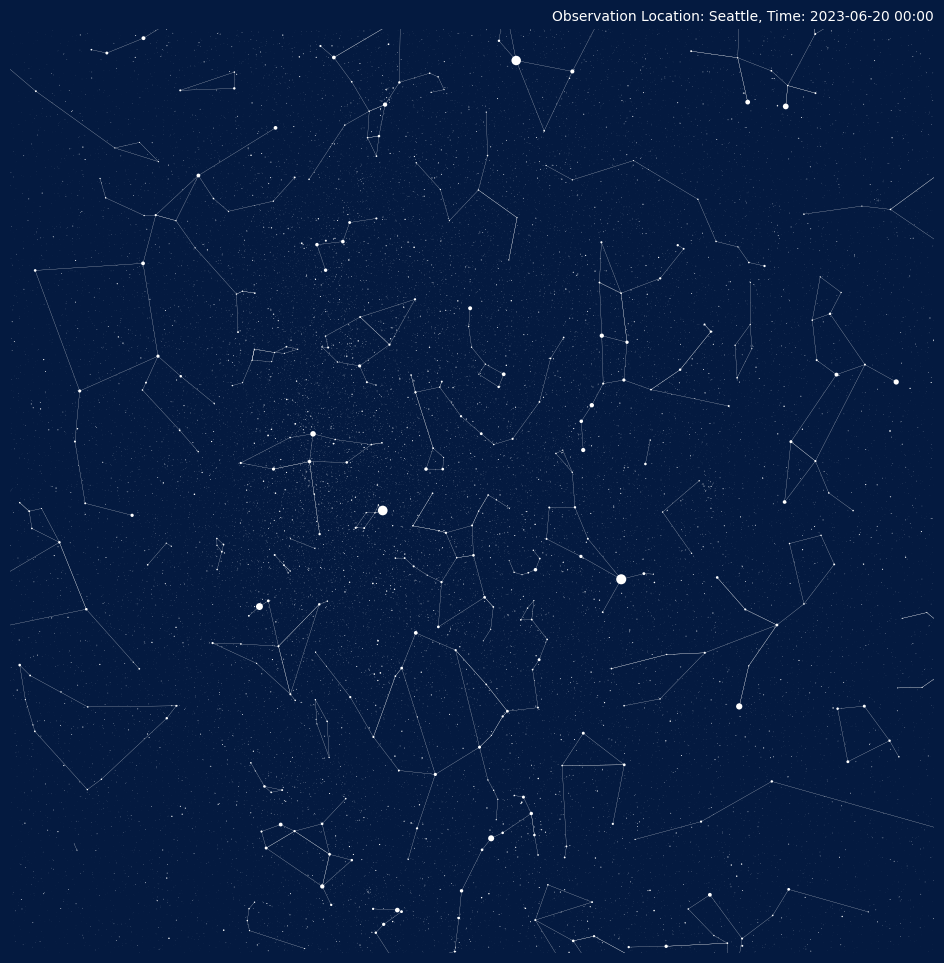

In [50]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection
from datetime import datetime
import numpy as np

def create_star_chart(location, when, chart_size, max_star_size):
    stars, edges_star1, edges_star2 = collect_celestial_data(location, when)
    # Define the number of stars and brightness of stars to include
    limiting_magnitude = 10
    bright_stars = (stars.magnitude <= limiting_magnitude)
    magnitude = stars['magnitude'][bright_stars]
    marker_size = max_star_size * 10 ** (magnitude / -2.5)
    
    # Calculate the constellation lines
    xy1 = stars[['x', 'y']].loc[edges_star1].values
    xy2 = stars[['x', 'y']].loc[edges_star2].values
    lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)
    
    # Time to build the figure!
    fig, ax = plt.subplots(figsize=(chart_size, chart_size),facecolor='#041A40')
    
    # Draw the constellation lines.
    ax.add_collection(LineCollection(lines_xy, colors='#ffff', linewidths=0.15))
    
    # Draw the stars.
    ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
               s=marker_size, color='white', marker='.', linewidths=0,
               zorder=2)

    # Finally, add other settings
    ax.set_aspect('equal')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    plt.axis('off')
    when_datetime = datetime.strptime(when, '%Y-%m-%d %H:%M')
    plt.title(f"Observation Location: {location}, Time: {when_datetime.strftime('%Y-%m-%d %H:%M')}", loc='right',color = 'white', fontsize=10)
    filename = f"{location}_{when_datetime.strftime('%Y%m%d_%H%M')}.png"
    #plt.savefig(filename, format='png', dpi=1200)
    
    plt.show()
    plt.close()
    
    
# call the function above
location = 'Seattle'
when = '2023-06-20 00:00'
chart_size=12
max_star_size=200
create_star_chart(location, when, chart_size, max_star_size)

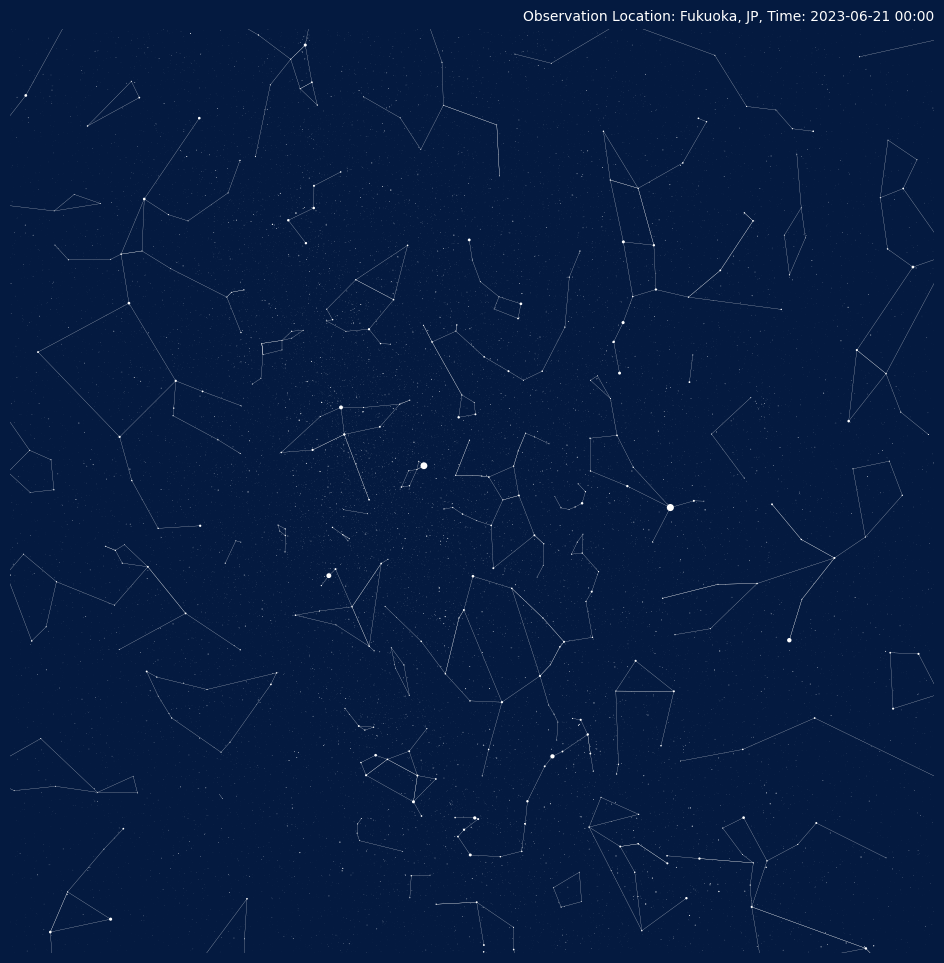

Plot saved for location Fukuoka, JP and time 2023-06-21 00:00


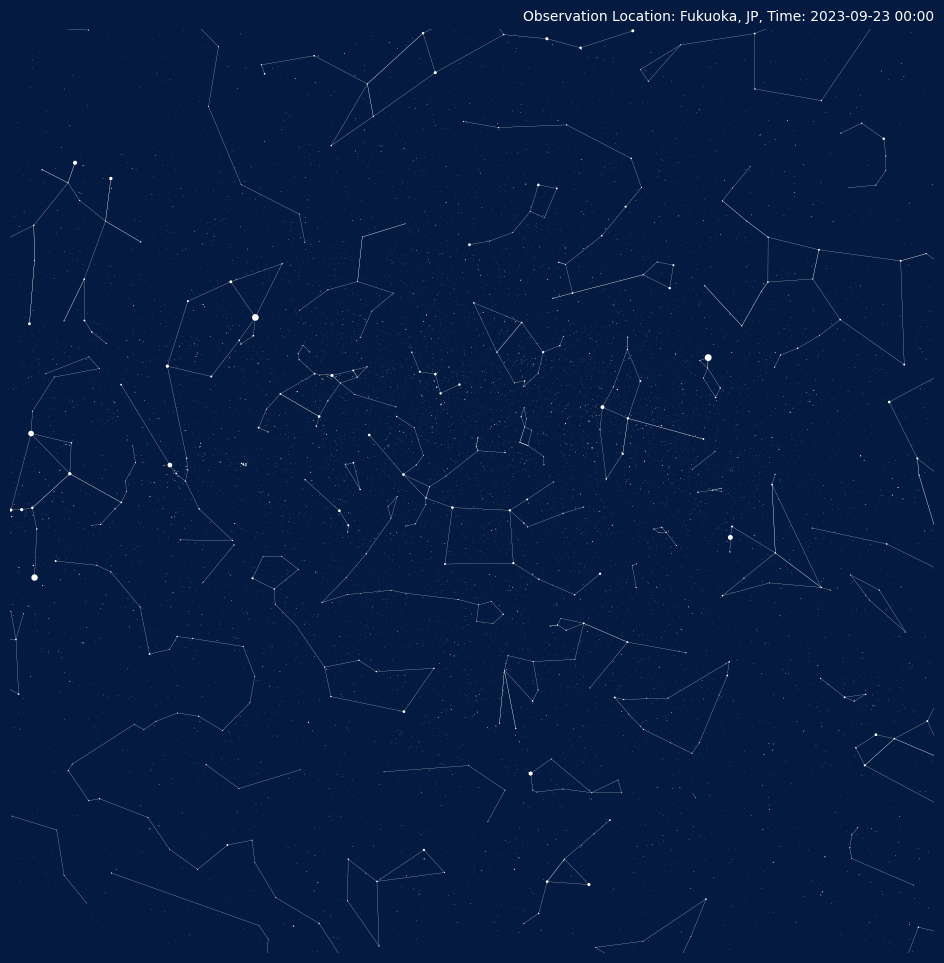

Plot saved for location Fukuoka, JP and time 2023-09-23 00:00


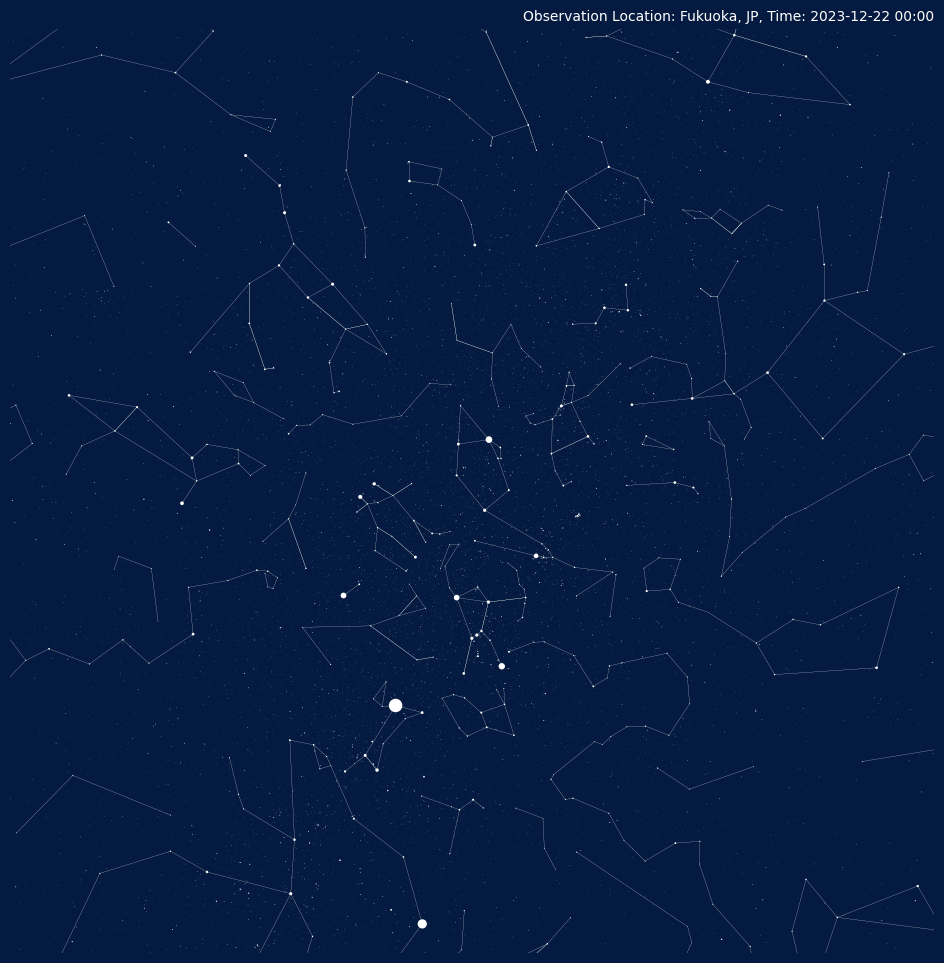

Plot saved for location Fukuoka, JP and time 2023-12-22 00:00


In [52]:
def generate_star_chart(locations, whens):
    for location in locations:
        for when in whens:
            chart_size = 12
            max_star_size = 100

            # generate the plot
            create_star_chart(location, when, chart_size, max_star_size)

            # save the plot
            when_datetime = datetime.strptime(when, '%Y-%m-%d %H:%M')
            filename = f"{location}_{when_datetime.strftime('%Y%m%d_%H%M')}.png"
            plt.savefig(filename, dpi=300)
            #plt.savefig(filename, format='svg', dpi=1200)
            plt.close()

            # print confirmation message
            print(f"Plot saved for location {location} and time {when}")
            
# Call the above loop function
locations = ['Fukuoka, JP']
whens = ['2023-06-21 00:00', '2023-09-23 00:00','2023-12-22 00:00']
generate_star_chart(locations, whens)